## Setup

In [161]:
import requests
import zipfile
import io
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import pytz
import numpy as np
import pandas as pd
import math
import warnings
import seaborn as sns
import os
import shutil
import re

from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from tqdm import tqdm

# Suppress specific warnings (in this case, FutureWarnings)
warnings.simplefilter(action='ignore', category=FutureWarning)

## Download the dataset

In [82]:
# Data from https://archive.ics.uci.edu/dataset/502/online+retail+ii
DATASET_URL = 'https://archive.ics.uci.edu/static/public/502/online+retail+ii.zip'
DATASET_FILENAME = 'online_retail_II.xlsx'

response = requests.get(DATASET_URL)
zip_bytes = io.BytesIO(response.content)

with zipfile.ZipFile(zip_bytes) as z:
    with z.open(DATASET_FILENAME) as file:
        online_retail_df = pd.read_excel(file)

## Explore the dataset

In [3]:
online_retail_df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.0,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.0,United Kingdom


In [4]:
online_retail_df['StockCode'] = online_retail_df['StockCode'].astype(str)

In [5]:
online_retail_df['Invoice'].value_counts()

Invoice
537434     675
538071     652
537638     601
537237     597
536876     593
          ... 
523981       1
523984       1
523985       1
C523988      1
C516462      1
Name: count, Length: 28816, dtype: int64

In [6]:
online_retail_df['StockCode'].value_counts()

StockCode
85123A    3516
22423     2221
85099B    2057
21212     1933
21232     1843
          ... 
90005B       1
90197C       1
90080        1
20904        1
21120        1
Name: count, Length: 4632, dtype: int64

In [7]:
online_retail_df['Description'].value_counts()

Description
WHITE HANGING HEART T-LIGHT HOLDER     3549
REGENCY CAKESTAND 3 TIER               2212
STRAWBERRY CERAMIC TRINKET BOX         1843
PACK OF 72 RETRO SPOT CAKE CASES       1466
ASSORTED COLOUR BIRD ORNAMENT          1457
                                       ... 
stock credited from royal yacht inc       1
VINTAGE METAL CAKE STAND CREAM            1
BLUE BAROQUE FLOCK CANDLE HOLDER          1
S/4 HEART CRYSTAL FRIDGE MAGNETS          1
dotcom email                              1
Name: count, Length: 4681, dtype: int64

In [8]:
online_retail_df['Quantity'].value_counts()

Quantity
 1       146118
 2        78131
 12       60682
 6        44431
 3        35517
          ...  
-1120         1
 2651         1
 528          1
 681          1
-177          1
Name: count, Length: 825, dtype: int64

In [9]:
online_retail_df['InvoiceDate'].value_counts()

InvoiceDate
2010-12-06 16:57:00    675
2010-12-09 14:09:00    652
2010-12-07 15:28:00    601
2010-12-06 09:58:00    597
2010-12-03 11:36:00    593
                      ... 
2010-02-24 16:40:00      1
2010-10-11 08:12:00      1
2010-02-24 16:43:00      1
2010-02-24 16:44:00      1
2010-09-28 15:24:00      1
Name: count, Length: 25296, dtype: int64

In [10]:
online_retail_df['Customer ID'].value_counts()

Customer ID
14911.0    5710
17841.0    5114
14606.0    3927
14156.0    2710
12748.0    2665
           ... 
18174.0       1
14827.0       1
17645.0       1
16443.0       1
13222.0       1
Name: count, Length: 4383, dtype: int64

In [11]:
online_retail_df['Country'].value_counts()

Country
United Kingdom          485852
EIRE                      9670
Germany                   8129
France                    5772
Netherlands               2769
Spain                     1278
Switzerland               1187
Portugal                  1101
Belgium                   1054
Channel Islands            906
Sweden                     902
Italy                      731
Australia                  654
Cyprus                     554
Austria                    537
Greece                     517
United Arab Emirates       432
Denmark                    428
Norway                     369
Finland                    354
Unspecified                310
USA                        244
Japan                      224
Poland                     194
Malta                      172
Lithuania                  154
Singapore                  117
RSA                        111
Bahrain                    107
Canada                      77
Hong Kong                   76
Thailand                    76


In [12]:
online_retail_df[['StockCode', 'Description']].value_counts()

StockCode  Description                       
85123A     WHITE HANGING HEART T-LIGHT HOLDER    3515
22423      REGENCY CAKESTAND 3 TIER              2212
21232      STRAWBERRY CERAMIC TRINKET BOX        1843
21212      PACK OF 72 RETRO SPOT CAKE CASES      1466
84879      ASSORTED COLOUR BIRD ORNAMENT         1457
                                                 ... 
35015      wet damages                              1
35004s     SET OF 3 SILVER FLYING DUCKS             1
84966C     Sold as A/B                              1
35004B     ?                                        1
35004p     SET OF 3 PINK FLYING DUCKS               1
Name: count, Length: 5070, dtype: int64

In [13]:
descriptions_per_stock_code = online_retail_df.groupby('StockCode')['Description'].nunique()
num_non_unique_descriptions = (descriptions_per_stock_code > 1).sum()
pct_non_unique_descriptions = (num_non_unique_descriptions / len(descriptions_per_stock_code)) * 100
print(f'Number of stock codes with more than one description: {num_non_unique_descriptions} ({pct_non_unique_descriptions:.0f}%)')

Number of stock codes with more than one description: 687 (15%)


In [14]:
descriptions_per_stock_code[descriptions_per_stock_code > 1].sort_values(ascending=False)

StockCode
22423        6
22734        5
21523        4
79000        4
22236        4
            ..
22326        2
22328        2
22329        2
22347        2
DCGSSGIRL    2
Name: Description, Length: 687, dtype: int64

In [15]:
online_retail_df.query('StockCode == 22423')['Description'].unique()

array([], dtype=object)

In [16]:
online_retail_df.query('StockCode == 22423 and Description != "REGENCY CAKESTAND 3 TIER"')

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country


In [17]:
online_retail_df.query('Quantity < 0')

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.0,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.0,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.0,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
...,...,...,...,...,...,...,...,...
525231,538159,21324,NaN,-18,2010-12-09 17:17:00,0.00,NaN,United Kingdom
525232,538158,20892,NaN,-32,2010-12-09 17:17:00,0.00,NaN,United Kingdom
525234,538161,46000S,Dotcom sales,-100,2010-12-09 17:25:00,0.00,NaN,United Kingdom
525235,538162,46000M,Dotcom sales,-100,2010-12-09 17:25:00,0.00,NaN,United Kingdom


In [18]:
online_retail_df['StockCode'].nunique()

4632

In [19]:
sold = online_retail_df.query('Quantity > 0')['Quantity'].sum()
returned = -online_retail_df.query('Quantity < 0')['Quantity'].sum()

print('Total units sold:', sold)
print('Total units returned:', returned)
print(f'Percentage returned: {returned/sold * 100:.0f}%')

Total units sold: 6011588
Total units returned: 579547
Percentage returned: 10%


In [20]:
sold_per_product = online_retail_df.query('Quantity > 0').groupby('StockCode')['Quantity'].sum()
sold_per_product.name = 'Sold'
returned_per_product = -online_retail_df.query('Quantity < 0').groupby('StockCode')['Quantity'].sum()
returned_per_product.name = 'Returned'

sold_and_returned_qunatities_by_product_df = pd.concat([sold_per_product, returned_per_product], axis=1)

returned_pct_by_product = sold_and_returned_qunatities_by_product_df['Returned'] / sold_and_returned_qunatities_by_product_df['Sold'] * 100

returned_pct_by_product.sort_values()

StockCode
47503F       0.019444
21523        0.025994
22571        0.027397
21524        0.027878
22549        0.028580
               ...   
DCGS0059          NaN
DCGS0060          NaN
DCGSLBOY          NaN
DCGSLGIRL         NaN
GIFT              NaN
Length: 4632, dtype: float64

In [21]:
nothing_sold_mask = sold_and_returned_qunatities_by_product_df['Sold'].isna()
sold_and_returned_qunatities_by_product_df[nothing_sold_mask]

,Sold,Returned
StockCode,,
10124C,NaN,5.0
15002,NaN,1000.0
15060A,NaN,8.0
16065A,NaN,2.0
16131,NaN,1.0
...,...,...
DCGS0059,NaN,8.0
DCGS0060,NaN,3.0
DCGSLBOY,NaN,16.0


In [22]:
online_retail_df.query('StockCode == 15002')

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country


In [23]:
online_retail_df['InvoiceDate'].describe()

count                           525461
mean     2010-06-28 11:37:36.845017856
min                2009-12-01 07:45:00
25%                2010-03-21 12:20:00
50%                2010-07-06 09:51:00
75%                2010-10-15 12:45:00
max                2010-12-09 20:01:00
Name: InvoiceDate, dtype: object

In [24]:
online_retail_df.query('Quantity > 0').groupby('StockCode')['InvoiceDate'].agg(['min', 'max']).describe()

,min,max
count,4317,4317
mean,2010-01-18 06:32:43.071577600,2010-10-09 16:00:31.035441152
min,2009-12-01 07:45:00,2009-12-01 13:07:00
25%,2009-12-01 14:28:00,2010-10-11 10:33:00
50%,2009-12-04 12:37:00,2010-12-05 16:24:00
75%,2010-01-15 12:22:00,2010-12-09 13:47:00
max,2010-12-09 14:09:00,2010-12-09 20:01:00


In [25]:
online_retail_df['InvoiceDate'].max()

Timestamp('2010-12-09 20:01:00')

In [26]:
product_and_date = online_retail_df.query('Quantity > 0')[['StockCode', 'InvoiceDate']]
product_and_date['StockCode'] = product_and_date['StockCode'].astype('str')
product_and_date.loc[:,'InvoiceDate'] = pd.to_datetime(product_and_date['InvoiceDate'].dt.date)
product_and_date.groupby(['StockCode']).nunique().sort_values(by='InvoiceDate', ascending=False).head(20)

,InvoiceDate
StockCode,
85123A,306
20725,304
21212,304
21232,303
84991,300
21080,300
21754,299
21931,298
85099B,297


In [27]:
product_and_date.groupby(['StockCode']).nunique().sort_values(by='InvoiceDate', ascending=False).describe(
    percentiles=[0.10, 0.25, 0.50, 0.75, 0.80, 0.90, 0.99]
)

,InvoiceDate
count,4317.000000
mean,61.952050
std,66.630121
min,1.000000
10%,3.000000
25%,12.000000
50%,38.000000
75%,89.000000
80%,107.000000
90%,166.000000


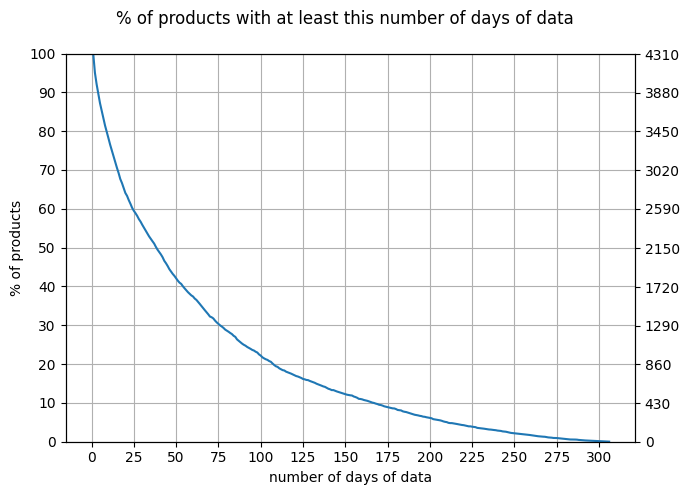

In [30]:
distinct_dates = product_and_date.groupby(['StockCode']).nunique()
cdf = np.array([(distinct_dates >= num_days).sum().iloc[0] for num_days in range(0, distinct_dates.max().values[0] + 1)]) / len(distinct_dates)
cdf = cdf * 100

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
ax_right = ax.twinx()

fig.suptitle('% of products with at least this number of days of data')

ax.plot(cdf)

n_products = len(distinct_dates)
pct_yticks = np.arange(0, 100 + 1, 10)
abs_yticks = ((pct_yticks * n_products / 100) // 10) * 10

ax.set_yticks(pct_yticks)
ax.set_ylim(0, 100)
ax_right.set_yticks(abs_yticks)
ax_right.set_ylim(ax.get_ylim())
ax_right.set_ylim(0, n_products)
ax.set_xticks(np.arange(0, cdf.size + 1, 25))
ax.set_xlabel('number of days of data')
ax.set_ylabel('% of products')
ax.grid(True, which='both')

plt.tight_layout()
plt.show()

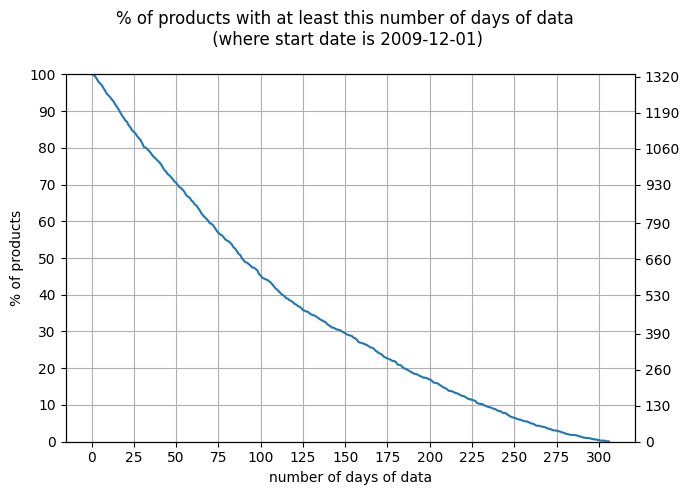

In [31]:
start_date_mask = product_and_date.groupby('StockCode')['InvoiceDate'].min() == '2009-12-01'
filtered_distinct_dates = distinct_dates.sort_index()[start_date_mask.sort_index()]
cdf = np.array([(filtered_distinct_dates >= num_days).sum().iloc[0] for num_days in range(0, filtered_distinct_dates.max().values[0] + 1)]) / len(filtered_distinct_dates)
cdf = cdf * 100

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7,5))
ax_right = ax.twinx()

fig.suptitle('% of products with at least this number of days of data\n (where start date is 2009-12-01)')

ax.plot(cdf)

n_products = len(filtered_distinct_dates)
pct_yticks = np.arange(0, 100 + 1, 10)
abs_yticks = ((pct_yticks * n_products / 100) // 10) * 10

ax.set_yticks(pct_yticks)
ax.set_ylim(0, 100)
ax_right.set_yticks(abs_yticks)
ax_right.set_ylim(ax.get_ylim())
ax_right.set_ylim(0, n_products)
ax.set_xticks(np.arange(0, cdf.size + 1, 25))
ax.set_xlabel('number of days of data')
ax.set_ylabel('% of products')
ax.grid(True, which='both')

plt.tight_layout()
plt.show()


In [32]:
filtered_data = online_retail_df[['InvoiceDate', 'StockCode', 'Quantity']].query('Quantity > 0')
filtered_data['InvoiceDate'] = pd.to_datetime(filtered_data['InvoiceDate'].dt.date)
correct_start_date_stock_codes = filtered_data.groupby('StockCode')['InvoiceDate'].min().to_frame().query('InvoiceDate == "2009-12-01"').index.values

enough_days_stock_codes = filtered_data.groupby('StockCode')['InvoiceDate'].nunique().to_frame().query('InvoiceDate >= 180').index.values

filtered_data = filtered_data[filtered_data['StockCode'].isin(correct_start_date_stock_codes) & filtered_data['StockCode'].isin(enough_days_stock_codes)]
filtered_data = filtered_data.groupby(['InvoiceDate', 'StockCode']).sum().fillna(0).reset_index()

In [33]:
filtered_data

,InvoiceDate,StockCode,Quantity
0,2009-12-01,10002,12
1,2009-12-01,15036,55
2,2009-12-01,15056BL,18
3,2009-12-01,15056N,30
4,2009-12-01,20674,1
...,...,...,...
66430,2010-12-09,85152,25
66431,2010-12-09,85232B,2
66432,2010-12-09,DOT,5
66433,2010-12-09,M,1


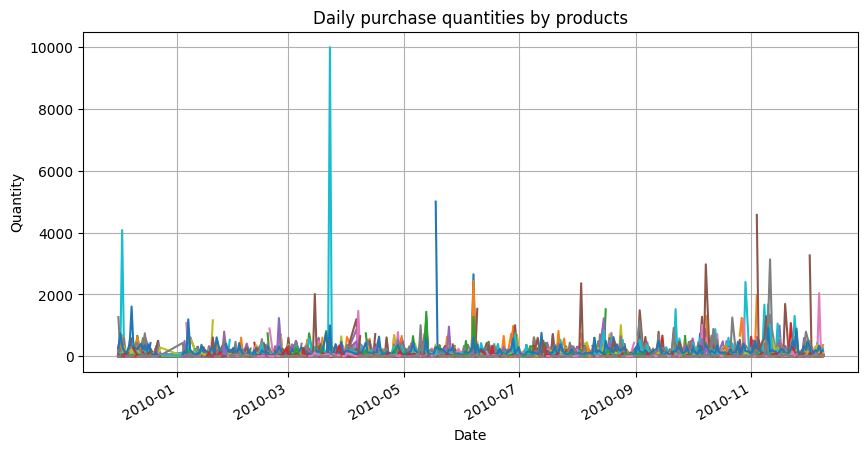

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

pivoted_data = filtered_data.pivot(
    index='InvoiceDate',
    columns='StockCode',
    values='Quantity',
)

pivoted_data.plot(ax=ax)

ax.set_title('Daily purchase quantities by products')
ax.set_xlabel('Date')
ax.set_ylabel('Quantity')
ax.legend().remove()
ax.grid(True, which='both')

<Axes: xlabel='InvoiceDate'>

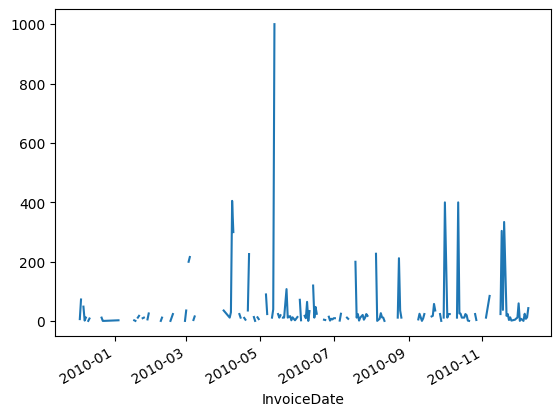

In [35]:
pivoted_data['10002'].plot()

In [36]:
pivoted_data['10002'].isna().sum() / pivoted_data['10002'].size

np.float64(0.39087947882736157)

In [37]:
product_and_date

,StockCode,InvoiceDate
0,85048,2009-12-01
1,79323P,2009-12-01
2,79323W,2009-12-01
3,22041,2009-12-01
4,21232,2009-12-01
...,...,...
525456,22271,2010-12-09
525457,22750,2010-12-09
525458,22751,2010-12-09
525459,20970,2010-12-09


In [45]:
unique_dates = product_and_date.groupby('StockCode').agg(['min', 'max', 'nunique'])
unique_dates.columns = unique_dates.columns.droplevel(0)
unique_dates['num_days_spanned'] = (unique_dates['max'] - unique_dates['min']).dt.days + 1
unique_dates['density'] = unique_dates['nunique'] / unique_dates['num_days_spanned']
unique_dates

,min,max,nunique,num_days_spanned,density
StockCode,,,,,
10002,2009-12-01,2010-12-09,187,374,0.500000
10002R,2009-12-02,2010-01-25,3,55,0.054545
10080,2009-12-02,2010-11-21,6,355,0.016901
10109,2009-12-03,2009-12-03,1,1,1.000000
10120,2009-12-01,2010-12-08,42,373,0.112601
...,...,...,...,...,...
gift_0001_60,2010-01-29,2010-08-09,2,193,0.010363
gift_0001_70,2010-01-29,2010-08-09,3,193,0.015544
gift_0001_80,2009-12-14,2010-08-09,2,239,0.008368


In [46]:
unique_dates.query('nunique >= 180 and density >= 0.6').sort_values(by='density', ascending=False)

,min,max,nunique,num_days_spanned,density
StockCode,,,,,
22411,2010-01-29,2010-12-09,261,315,0.828571
22470,2010-04-22,2010-12-09,191,232,0.823276
22383,2010-01-22,2010-12-09,264,322,0.819876
22423,2010-03-15,2010-12-09,221,270,0.818519
85123A,2009-12-01,2010-12-09,306,374,0.818182
...,...,...,...,...,...
22150,2009-12-01,2010-12-09,227,374,0.606952
21974,2009-12-02,2010-12-06,224,370,0.605405
21165,2009-12-01,2010-12-09,226,374,0.604278


<Axes: xlabel='InvoiceDate'>

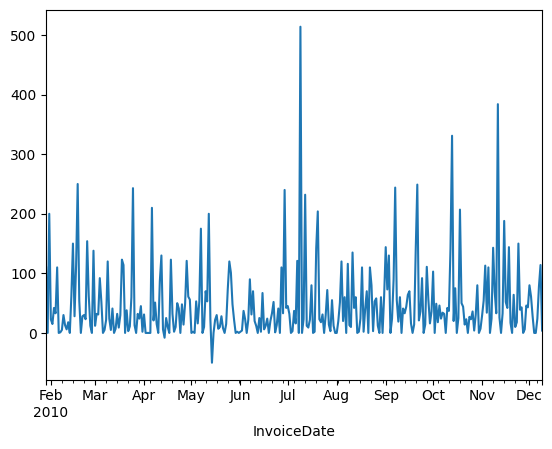

In [63]:
online_retail_df.query('StockCode == "22411"').groupby('InvoiceDate')['Quantity'].sum().resample('1d').sum().sort_index().plot()

<Axes: xlabel='InvoiceDate'>

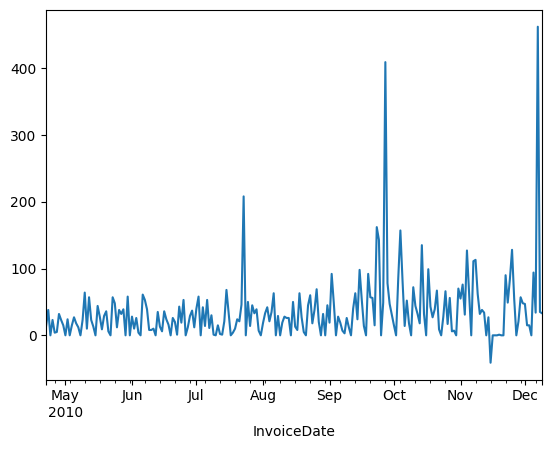

In [64]:
online_retail_df.query('StockCode == "22470"').groupby('InvoiceDate')['Quantity'].sum().resample('1d').sum().sort_index().plot()

<Axes: xlabel='InvoiceDate'>

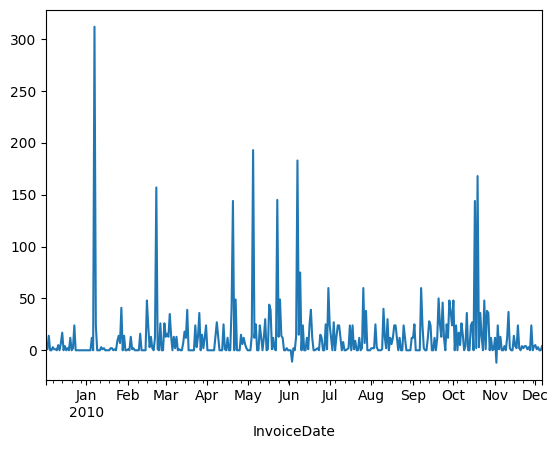

In [67]:
online_retail_df.query('StockCode == "21974"').groupby('InvoiceDate')['Quantity'].sum().resample('1d').sum().sort_index().plot()

<Axes: xlabel='InvoiceDate'>

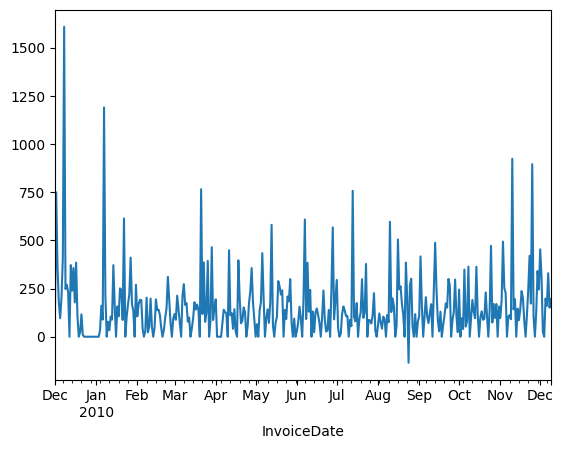

In [68]:
online_retail_df.query('StockCode == "85123A"').groupby('InvoiceDate')['Quantity'].sum().resample('1d').sum().sort_index().plot()

In [73]:
unique_dates.query('nunique >= 180 and density >= 0.6').describe(percentiles=[0.10, 0.25, 0.50, 0.75, 0.90])

,min,max,nunique,num_days_spanned,density
count,194,194,194.000000,194.000000,194.000000
mean,2009-12-17 00:00:00,2010-12-08 01:14:13.608247296,248.664948,357.051546,0.697996
min,2009-12-01 00:00:00,2010-08-01 00:00:00,180.000000,232.000000,0.601604
10%,2009-12-01 00:00:00,2010-12-09 00:00:00,201.900000,280.000000,0.620560
25%,2009-12-01 00:00:00,2010-12-09 00:00:00,231.250000,373.250000,0.647493
50%,2009-12-01 00:00:00,2010-12-09 00:00:00,248.000000,374.000000,0.689840
75%,2009-12-01 00:00:00,2010-12-09 00:00:00,269.000000,374.000000,0.744136
90%,2010-03-04 16:48:00,2010-12-09 00:00:00,287.700000,374.000000,0.787968
max,2010-04-22 00:00:00,2010-12-09 00:00:00,306.000000,374.000000,0.828571
std,NaN,NaN,29.837489,36.114060,0.061352


In [75]:
unique_dates.query('nunique >= 180 and density >= 0.6 and min == "2009-12-01"')

,min,max,nunique,num_days_spanned,density
StockCode,,,,,
15056BL,2009-12-01,2010-12-09,237,374,0.633690
15056N,2009-12-01,2010-12-09,246,374,0.657754
20676,2009-12-01,2010-12-09,253,374,0.676471
20677,2009-12-01,2010-12-09,227,374,0.606952
20685,2009-12-01,2010-12-09,286,374,0.764706
...,...,...,...,...,...
85123A,2009-12-01,2010-12-09,306,374,0.818182
85150,2009-12-01,2010-12-09,258,374,0.689840
85152,2009-12-01,2010-12-09,276,374,0.737968


<Axes: xlabel='InvoiceDate'>

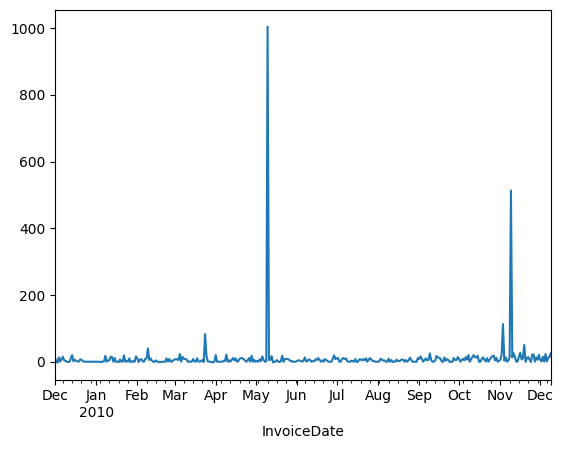

In [76]:
online_retail_df.query('StockCode == "POST"').groupby('InvoiceDate')['Quantity'].sum().resample('1d').sum().sort_index().plot()

In [79]:
online_retail_df.query('StockCode == "POST"')['Description'].unique()

array(['POSTAGE', nan], dtype=object)

In [96]:
np.sort(online_retail_df['StockCode'].astype(str).unique())

array(['10002', '10002R', '10080', ..., 'gift_0001_80', 'gift_0001_90',
       'm'], shape=(4632,), dtype=object)

In [103]:
stock_codes = unique_dates.query('nunique >= 180 and density >= 0.6 and min == "2009-12-01"').index.values
online_retail_df[online_retail_df['StockCode'].isin(stock_codes)].query('Quantity > 0')['Description'].unique()

array(['HANGING HEART ZINC T-LIGHT HOLDER',
       'RED/WHITE DOTS RUFFLED UMBRELLA',
       'SET/3 RUSSIAN DOLL STACKING TINS', 'POSTAGE',
       'WHITE HANGING HEART T-LIGHT HOLDER',
       'JUMBO BAG RED WHITE SPOTTY ', 'WOODEN FRAME ANTIQUE WHITE ',
       'PINK 3 PIECE MINI DOTS CUTLERY SET',
       'BLUE 3 PIECE MINI DOTS CUTLERY SET',
       "PINK FAIRY CAKE CHILD'S APRON",
       'RED 3 PIECE MINI DOTS CUTLERY SET', 'EDWARDIAN PARASOL BLACK',
       'EDWARDIAN PARASOL NATURAL', 'PACK 20 ENGLISH ROSE PAPER NAPKINS',
       'JUMBO  BAG BAROQUE BLACK WHITE', 'JUMBO BAG STRAWBERRY',
       'SINGLE HEART ZINC T-LIGHT HOLDER', 'TEA TIME TEA TOWELS ',
       'CREAM CUPID HEARTS COAT HANGER', nan, 'RED RETROSPOT JUMBO BAG ',
       'JUMBO BAG RED RETROSPOT', 'PINK FAIRY CAKE CHILDRENS APRON',
       'SET OF 3 BABUSHKA STACKING TINS',
       'PINK 3 PIECE POLKADOT CUTLERY SET',
       'BLUE 3 PIECE POLKADOT CUTLERY SET',
       'RED 3 PIECE RETROSPOT CUTLERY SET', 'RED RETROSPOT UMBRELL

In [106]:
online_retail_df[online_retail_df['StockCode'].isin(stock_codes)].query('Quantity > 0')['Description'].nunique()

27

In [116]:
online_retail_df.query('Quantity > 0').groupby('Description')['StockCode'].nunique().to_frame().query('StockCode > 1').head(16)

,StockCode
Description,
3D DOG PICTURE PLAYING CARDS,2
3D SHEET OF CAT STICKERS,2
3D SHEET OF DOG STICKERS,2
3D SHEET OF SEA WORLD STICKERS,2
4 BURGUNDY WINE DINNER CANDLES,2
4 FESTIVE GREEN DINNER CANDLES,2
4 ROSE PINK DINNER CANDLES,2
4 SKY BLUE DINNER CANDLES,2
75 BLACK FAIRY CAKE CASES,2


In [120]:
online_retail_df.query('Quantity > 0').groupby('Description')['StockCode'].agg(['nunique', 'unique']).query('nunique > 1').head(40)

,nunique,unique
Description,,
3D DOG PICTURE PLAYING CARDS,2,"[84558A, 84558a]"
3D SHEET OF CAT STICKERS,2,"[84559B, 84559b]"
3D SHEET OF DOG STICKERS,2,"[84559A, 84559a]"
3D SHEET OF SEA WORLD STICKERS,2,"[84559D, 84559d]"
4 BURGUNDY WINE DINNER CANDLES,2,"[72801G, 72801g]"
4 FESTIVE GREEN DINNER CANDLES,2,"[72801e, 72801E]"
4 ROSE PINK DINNER CANDLES,2,"[72801C, 72801c]"
4 SKY BLUE DINNER CANDLES,2,"[72801D, 72801d]"
75 BLACK FAIRY CAKE CASES,2,"[84989B, 84989b]"


In [121]:
online_retail_df.query('Quantity > 0').groupby('Description')['StockCode'].agg(['nunique', 'unique']).query('nunique > 2').head(40)

,nunique,unique
Description,,
?,3,"[21314, 21900, 48188]"
COLOURING PENCILS BROWN TUBE,3,"[10133, 10135, 10134]"
"METAL SIGN,CUPCAKE SINGLE HOOK",6,"[82613B, 82613C, 82613A, 82613a, 82613b, 82613c]"
WHITE BAMBOO RIBS LAMPSHADE,3,"[40002, 40003, 40001]"
checked,3,"[21133, 35980C, 21018]"
found,3,"[17109B, 22077, 16151A]"
mailout,3,"[22502, 22501, 22961]"
temp,4,"[22359, 22361, 22360, 22363]"


In [134]:
temp = online_retail_df.query('Quantity > 0')
temp.loc[:,'Description'] = temp['Description'].str.lower().str.strip()
temp.loc[:,'StockCode'] = temp['StockCode'].astype(str).str.lower().str.strip()
temp.groupby('Description')['StockCode'].agg(['nunique', 'unique']).query('nunique == 2')

,nunique,unique
Description,,
"acrylic jewel snowflake,blue",2,"[35817b, 35815b]"
amazon,2,"[22139, 22734]"
amazon adjustment,2,"[22687, 22734]"
amendment,2,"[21523, 22734]"
bathroom metal sign,2,"[82580, 21171]"
black silouette candle plate,2,"[72780, 72781]"
blue flock glass candleholder,2,"[79328, 79337]"
brocante shelf with hooks,2,"[22829, 22832]"
columbian candle rectangle,2,"[72131, 72133]"


In [135]:
temp.groupby('Description')['StockCode'].agg(['nunique', 'unique']).query('nunique > 2')

,nunique,unique
Description,,
?,3,"[21314, 21900, 48188]"
checked,3,"[21133, 35980c, 21018]"
colouring pencils brown tube,3,"[10133, 10135, 10134]"
columbian candle round,4,"[72127, 72128, 72130, 72129]"
found,4,"[17109b, 22077, 22864, 16151a]"
mailout,5,"[22502, 22501, 22961, 22963, 22962]"
"metal sign,cupcake single hook",3,"[82613b, 82613c, 82613a]"
modern christmas tree candle,3,"[20884, 20881, 20882]"
temp,4,"[22359, 22361, 22360, 22363]"


In [139]:
temp.groupby('StockCode')['Description'].agg(['nunique', 'unique']).query('nunique == 2')

,nunique,unique
StockCode,,
15058b,2,"[pink white spots garden parasol, pink polkado..."
16012,2,"[food/drink spunge stickers, food/drink sponge..."
16151a,2,"[flower des blue handbag/orang handl, found]"
16161u,2,"[wrap,suki and friends, wrap suki and friends]"
17109b,2,"[flower fairy incense lavender, found]"
...,...,...
85232b,2,"[set/3 russian doll stacking tins, set of 3 ba..."
90208,2,"[pair of enamel flower cluster slide, pair of ..."
adjust,2,"[adjustment by john on 26/01/2010 16, adjustme..."


In [140]:
temp.groupby('StockCode')['Description'].agg(['nunique', 'unique']).query('nunique > 2')

,nunique,unique
StockCode,,
20685,4,"[red spotty coir doormat, door mat red spot, n..."
21523,4,"[fancy font home sweet home doormat, door mat ..."
21524,3,"[spotty home sweet home doormat, door mat spo..."
21955,3,"[union jack guns & roses doormat, doormat uni..."
22139,4,"[retro spot tea set ceramic 11 pc, 11 pc ceram..."
22191,3,"[eau de nil diner wall clock, ivory wall clock..."
22333,3,"[retro sport party bag + sticker set, retro sp..."
22343,3,"[party pizza dish red white spot, party pizza ..."
22344,4,"[party pizza dish pink+white spot, party pizza..."


In [142]:
online_retail_df.query('StockCode == 20685')['Description'].str.lower().str.strip().unique()

array(['red spotty coir doormat', 'door mat red spot', nan,
       'doormat red spot', 'doormat red retrospot'], dtype=object)

In [123]:
online_retail_df['Description'].unique()

array(['15CM CHRISTMAS GLASS BALL 20 LIGHTS', 'PINK CHERRY LIGHTS',
       ' WHITE CHERRY LIGHTS', ..., '*Boombox Ipod Classic', 'faulty',
       'Dotcom sales'], shape=(4682,), dtype=object)

In [144]:
def normalize(text):
    if pd.isnull(text):
        return np.nan
    text = text.lower()  # lowercase
    text = re.sub(r'[^a-z0-9\s]', '', text)  # remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra spaces
    return text

In [162]:
normalized = online_retail_df.query('Quantity > 0')['Description'].astype(str).apply(normalize)

# Create a mapping of original to canonical names
canonical = {}
threshold = 85  # similarity score threshold

for item in tqdm(normalized.dropna().unique()):
    matched = None
    for key in canonical:
        if fuzz.ratio(item, key) >= threshold:
            matched = key
            break
    if matched:
        canonical[item] = matched
    else:
        canonical[item] = item

100%|███████████████████████████████████████| 4468/4468 [05:23<00:00, 13.81it/s]


In [170]:
for key in canonical:
    if key != canonical[key]:
        print(key, '-->', canonical[key])

home building block word --> love building block word
bath building block word --> home building block word
feltcraft doll maria --> feltcraft doll rosie
feltcraft doll emily --> feltcraft doll maria
charlie lola blue hot water bottle --> charlielola red hot water bottle
charlielola pink hot water bottle --> charlielola red hot water bottle
charlie lola red hot water bottle --> charlielola red hot water bottle
carrot charlielola coaster set --> tomato charlielola coaster set
charlie lola wastepaper bin flora --> charlie lola wastepaper bin blue
kings choice giant tube matches --> kings choice small tube matches
blue felt hanging heart w flower --> pink felt hanging heart w flower
set6 woodland paper plates --> set6 woodland paper cups
red hanging heart tlight holder --> hanging heart zinc tlight holder
feltcraft doll molly --> feltcraft doll emily
girls alphabet iron on patches --> boys alphabet iron on patches
red stripe ceramic drawer knob --> red spot ceramic drawer knob
blue stripe

In [171]:
len([1 for key in canonical if key != canonical[key]])

1089

In [158]:
fuzz.ratio('coffee mug pink paisley design', 'coffee mug blue paisley design')

87

### Things to do
* Upper case the stock codes to avoid differences due to lower case
* Remove rows with negative quantities
* Lower case descriptions, strip punctuation, and spaces.
* Fuzz similar descriptions together
* Remove products with the following descriptions:
   * '?'
   * 'checked'
   * 'found'
   * 'mailout'
   * 'temp'
   * 'update'
   * 'damaged'
   * 'amazon
   * 'amazon adjustment'
   * 'amendment'
   * 'this is a test product.'
   * 'temp'
   * Null descriptions
* Remove products with less than 180 days of data
* Remove products with a density of days of less than 60%